In [5]:
from carbontracker import parser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns # improves plot aesthetics
import os

directory = os.getcwd()
os.chdir(directory)


In [8]:
dataSet = 'Alzheimer_MRI'

parser.print_aggregate(log_dir= 'Data/Loss_' + dataSet + '/CarbonLogs')
logs = parser.parse_all_logs(log_dir = 'Data/Loss_' + dataSet + '/CarbonLogs')
var_names = []  # Declare empty list to store var_names

for log in logs:
    var_name = ((log['output_filename']).split("CarbonLogs/")[1]).split("_")[0]
    var_names.append(var_name)
    output_file = log['output_filename']
    standard_file = log['standard_filename']
    early_stop = log['early_stop']
    actual_consumption = log['actual']
    predicted_consumption = log['pred']
    #gpu_devices = log['components']['gpu']['devices']
    
    # Save variables using var_name as the prefix
    locals()[f'{var_name}_output_file'] = output_file
    locals()[f'{var_name}_standard_file'] = standard_file
    locals()[f'{var_name}_early_stop'] = early_stop
    locals()[f'{var_name}_actual_consumption'] = actual_consumption
    locals()[f'{var_name}_predicted_consumption'] = predicted_consumption
    #locals()[f'{var_name}_gpu_devices'] = gpu_devices

The training of models in this work is estimated to use 0.000 kWh of electricity contributing to 0.000 kg of CO2eq. Measured by carbontracker (https://github.com/lfwa/carbontracker).


In [9]:
def _invert(x, limits):
    """inverts a value x on a scale from
    limits[0] to limits[1]"""
    return limits[1] - (x - limits[0])

def _scale_data(data, ranges):
    """scales data[1:] to ranges[0],
    inverts if the scale is reversed"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    d = data[0]
    if x1 > x2:
        d = _invert(d, (x1, x2))
        x1, x2 = x2, x1
    sdata = [d]
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        if y1 > y2:
            d = _invert(d, (y1, y2))
            y1, y2 = y2, y1
        sdata.append((d-y1) / (y2-y1) 
                     * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges,
                 n_ordinate_levels=6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.9,0.9],polar=True,
                label = "axes{}".format(i)) 
                for i in range(len(variables))]
        l, text = axes[0].set_thetagrids(angles, 
                                         labels=variables)
        [txt.set_rotation(angle-90) for txt, angle 
             in zip(text, angles)]
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off")
            ax.xaxis.set_visible(False)
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i], 
                               num=n_ordinate_levels)
            gridlabel = ["{}".format(round(x,2)) 
                         for x in grid]
            if ranges[i][0] > ranges[i][1]:
                grid = grid[::-1] # hack to invert grid
                          # gridlabels aren't reversed
            gridlabel[0] = "" # clean up origin
            ax.set_rgrids(grid, labels=gridlabel,
                         angle=angles[i])
            #ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        # variables for plotting
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

KeyError: 'var1_actual_consumption'

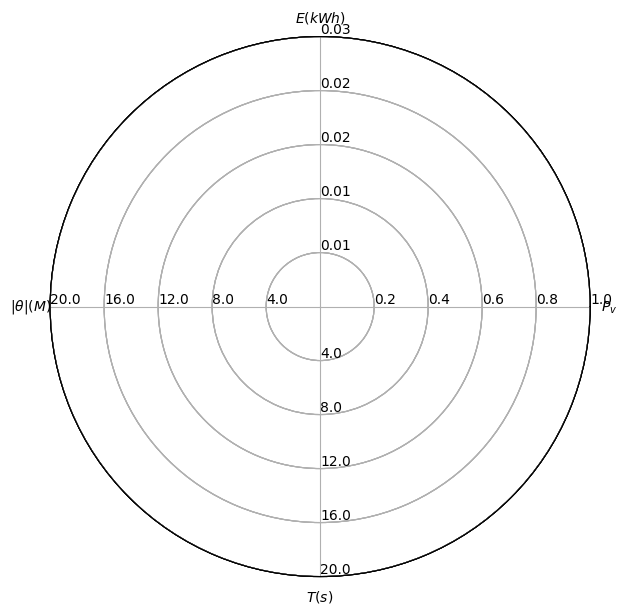

In [11]:
groups = {
    '128z128DenseNet_3525_2023-04-16T140552Z_carbontracker_err': ['var1', 'var2', 'var3'],
    '128z128DenseNet_3525_2023-04-16T140552Z_carbontracker_output': ['var4', 'var5', 'var6'],
    '128z128DenseNet_3525_2023-04-16T140552Z_carbontracker': ['var7', 'var8', 'var9']
}

# Plot variables in each group
for prefix, var_names in groups.items():
    variables = (r'$P_v$', r'$E(kWh)$', r'$|\theta|(M)$', r'$T(s)$')
    fig1 = plt.figure(figsize=(6, 6))
    radar = ComplexRadar(fig1, variables, [(0, 1), (0, 0.03), (0, 20), (0, 20)])
    for var_name in var_names:
        data = (0.85, locals()[f'{var_name}_actual_consumption']['energy (kWh)'], 10, locals()[f'{var_name}_actual_consumption']['duration (s)']/60)
        radar.plot(data, label=var_name)
        radar.fill(data, alpha=0.2)
    le = radar.ax.legend(loc='upper right', frameon=1, bbox_to_anchor=(1.3, 1.1))
    frame = le.get_frame()
    frame.set_facecolor('grey')
    frame.set_edgecolor('black')
    plt.title(f'Variables with prefix {prefix}')
    filename = f'{prefix}.png'  # Set filename as prefix
    filepath = os.path.join('/content/drive/MyDrive/Master/Loss_chest_xray/', filename)  # Change filepath
    plt.savefig(filepath, dpi=400, bbox_inches='tight')
    plt.show()